In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [37]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [38]:
path = tf.keras.utils.get_file('daily-min-temperatures.csv', 
                               'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
print (path)

C:\Users\Amir\.keras\datasets\daily-min-temperatures.csv


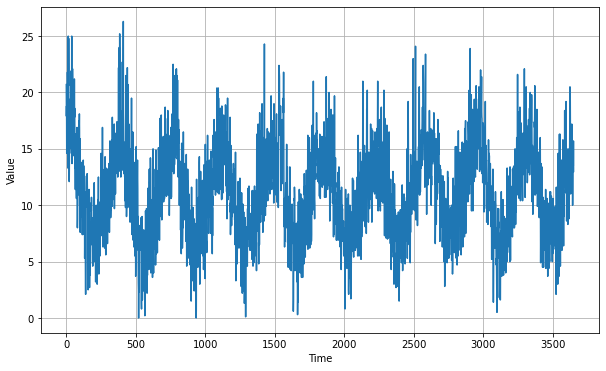

In [39]:
import csv
time_step = []
temps = []

with open(path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [40]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [41]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [42]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [43]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

In [45]:
# use generator here
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [46]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
generator = TimeseriesGenerator(x_train, x_train,
                               length = window_size, sampling_rate = 1, batch_size = batch_size, shuffle=True)

In [49]:
len(generator)

10

In [53]:
#for i in range(len(generator)):
x, y = generator[1]
x.shape
#print('x:%s => y:%s' % (x.flatten(), y))

(256, 64)

In [54]:
y.shape

(256,)

In [13]:
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [58]:
# CNN here

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="same",  # ="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

In [60]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [61]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [62]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [55]:
#history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
history = model.fit(generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


ValueError: in user code:

    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\Amir\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, None]


(1e-08, 0.0001, 0.0, 60.0)

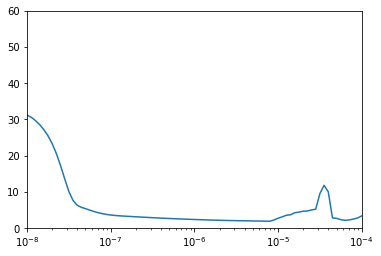

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [22]:
# use generator here
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [23]:
# RNN here
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [24]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

In [25]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [26]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 110ms/step - loss: 9.9820 - mae: 10.4701
Epoch 2/150
25/25 [==============================] - 3s 107ms/step - loss: 2.5293 - mae: 2.9921
Epoch 3/150
25/25 [==============================] - 3s 128ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 3s 116ms/step - loss: 1.8618 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 3s 108ms/step - loss: 1.8214 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 3s 108ms/step - loss: 1.7908 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 3s 110ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 3s 108ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 3s 104ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 3s 108ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [==================

In [27]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

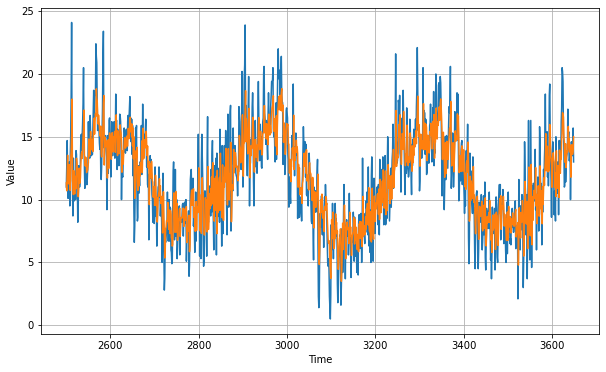

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796284

In [31]:
print(rnn_forecast)

[11.328011 10.704999 12.123924 ... 13.603875 13.795963 15.00827 ]
